<a href="https://www.kaggle.com/code/mohamedmoez2/image-caption-generator-flickr?scriptVersionId=136380783" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
# for managing files
import os
# for storing features
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# for providing UI about how much data processed
from tqdm.notebook import tqdm
# for extracting features from images data, and preprocessing data for model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# for text preprocessing, such as converting text to lowercase, filtering out stop words
from tensorflow.keras.preprocessing.text import Tokenizer
# for pading or truncating the sequence so that all sequences have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
# for compiling the model with loss function, optimizer or dataset training
from tensorflow.keras.models import Model
import tensorflow.keras.models as tf_models
# for converting labels or words into vectors (1 or 0), and model visualization
from tensorflow.keras.utils import to_categorical, plot_model
# for importing model layers
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
dataset_dir = '/kaggle/input/flickr8k'
features_dir = '/kaggle/input/Flickr-features'
work_dir = '/kaggle/working'

In [31]:
# load vgg16 model to extract features from images
model = VGG16()
# restructure the model to only extract features and not classify the image
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553476096/553467096 [==============================] - 24s 0us/step


# Preprocess Image & Extract Features from it

In [4]:
features = {}
# directory = os.path.join(dataset_dir, 'Images')

# for imgName in tqdm(os.listdir(directory)):
#     # load the image from file
#     imgPath = directory + '/' + imgName
#     image = load_img(imgPath, target_size=(224, 224))
#     # get image ID (removing file extension)
#     imageID = imgName.split('.')[0]
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape image
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg model
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)

#     # store that feature in the images' features list
#     features[imageID] = feature

# Store Image Features

In [5]:
# # store features in pickle
# pickle.dump(features, open(os.path.join(work_dir, 'features.pkl'), 'wb'))

# Load Image Features

In [6]:
# load features using pickle
with open(os.path.join(features_dir, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load Captions

In [7]:
with open(os.path.join(dataset_dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

# Map Captions to Images

In [8]:
# map images' captions to each image
imgsWithCaptions = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    imageName, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    imageID = imageName.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create a list for new image
    if imageID not in imgsWithCaptions:
        imgsWithCaptions[imageID] = []
    # store the caption
    imgsWithCaptions[imageID].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(imgsWithCaptions)

8092

# Preprocess Caption Data

In [10]:
def clean(imgsWithCaptions):
    for image, captions in imgsWithCaptions.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # Check first if it's already preprocessed
            if caption.startswith('sseq') & caption.endswith('eseq'):
                return caption
            # Convert any uppercase to lowercase
            caption = caption.lower()
            # Remove special characters
            caption = re.sub(r'[^\w\s]', '', caption)
            # Add start and end tokens to the caption
            caption = 'sseq ' + caption + ' eseq'
            # Remove extra whitespaces or any single character
            caption = " ".join([word for word in caption.split() if len(word)>1])
            captions[i] = caption

In [11]:
# before preprocess of text
imgsWithCaptions['10815824_2997e03d76']

['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .',
 'A girl and her horse stand by a fire .',
 "A girl holding a horse 's lead behind a fire .",
 '"A man   and girl and two horses are near a contained fire ."',
 'Two people and two horses watching a fire .']

In [12]:
# preprocess the text
clean(imgsWithCaptions)

In [13]:
# after preprocess of text
imgsWithCaptions['10815824_2997e03d76']

['sseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel eseq',
 'sseq girl and her horse stand by fire eseq',
 'sseq girl holding horse lead behind fire eseq',
 'sseq man and girl and two horses are near contained fire eseq',
 'sseq two people and two horses watching fire eseq']

In [14]:
allCaptions = []
for imageID in imgsWithCaptions:
    for caption in imgsWithCaptions[imageID]:
        allCaptions.append(caption)

In [15]:
len(allCaptions)

40456

In [16]:
allCaptions[:10]

['sseq child in pink dress is climbing up set of stairs in an entry way eseq',
 'sseq girl going into wooden building eseq',
 'sseq little girl climbing into wooden playhouse eseq',
 'sseq little girl climbing the stairs to her playhouse eseq',
 'sseq little girl in pink dress going into wooden cabin eseq',
 'sseq black dog and spotted dog are fighting eseq',
 'sseq black dog and tricolored dog playing with each other on the road eseq',
 'sseq black dog and white dog with brown spots are staring at each other in the street eseq',
 'sseq two dogs of different breeds looking at each other on the road eseq',
 'sseq two dogs on pavement moving toward each other eseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(allCaptions)
uniqueWordsCount = len(tokenizer.word_index) + 1
uniqueWordsCount-1

8810

In [18]:
# Save the tokenizer
with open('new_captions_tokenizer.pickle', 'wb') as t:
    pickle.dump(tokenizer, t)

In [19]:
# Load the tokenizer
with open('new_captions_tokenizer.pickle', 'rb') as t:
    tokenizer = pickle.load(t)

In [20]:
# get maximum length of the caption available
maxCaptionLength = max(len(caption.split()) for caption in allCaptions)
maxCaptionLength

34

# Split (Train-Test) Images

In [40]:
imageIDs = list(imgsWithCaptions.keys())
splitPercentage = int(len(imageIDs) * 0.90)
trainImgs = imageIDs[:splitPercentage]
testImgs = imageIDs[splitPercentage:]

#print(splitPercentage)
print("train images: ",len(trainImgs),"\ntest  images: ",len(testImgs))
#len(train + test)

testImgs[-10:]

train images:  7282 
test  images:  810


['985067019_705fe4a4cc',
 '987907964_5a06a63609',
 '989754491_7e53fb4586',
 '989851184_9ef368e520',
 '990890291_afc72be141',
 '99171998_7cc800ceef',
 '99679241_adc853a5c0',
 '997338199_7343367d7f',
 '997722733_0cb5439472',
 '']

# Creating Data Generator for Training

In [22]:
#        'sseq  girl going into wooden building eseq'

#        (capt_VectorSeq)                             (newSeq)

#         sseq                                          girl
#         sseq girl                                     going
#         sseq girl going                               into
#         sseq girl going into                          wooden
#         sseq girl going into wooden                   building    
#         sseq girl going into wooden building          eseq

In [23]:
# function to train the model for predicting the caption sequence
import numpy as np

def sequenceGenerator(imageIDs, imgsWithCaptions, features, tokenizer, maxCaptionLength, uniqueWordsCount, batchSize):
    # X1_train, X2_train, Y_train
    img_feature_list, current_words_list, next_word_list = list(), list(), list()
    n = 0
    while 1:
        for imageID in imageIDs:
            n += 1
            debug_imageID = '10815824_2997e03d76'
            captions = imgsWithCaptions[imageID]
            # process each caption
            c = 1
            for caption in captions:
                # encode the sequence
                captionSeq = tokenizer.texts_to_sequences([caption])[0]
                # output the (captionSeq) for an example image to understand the sequence generation
                """ if imageID == debug_imageID:
                    print("\n\n-------------------- Caption [[ ", c, " ]] ---------------------\n")
                    print("captionSeq: ", captionSeq)
                    c += 1 """
                # split the sequence into input sequence, output sequence pairs
                for i in range(1, len(captionSeq)):
                    # split into input and output pairs
                    current_words, next_word = captionSeq[:i], captionSeq[i]
                    # debug the sequences
                    """ if imageID == debug_imageID:
                        print("\nBefore padding and encoding:\n")
                        print("seqIn: ", current_words)
                        print("seqOut: ", next_word) """
                    
                    # pad input sequence
                    current_words = pad_sequences([current_words], maxlen=maxCaptionLength)[0]
                    # encode output/next word (one hot encode), 
                    # which means that the output/next word is represented by a vector of size uniqueWordsCount 
                    # the index of the word is marked as 1 and the rest of the vector is filled with 0s, 
                    # that index indicates the token of the word in the tokenizer
                    next_word = to_categorical([next_word], num_classes=uniqueWordsCount)[0]
                    
                    """ if imageID == debug_imageID:
                        print("\nAfter padding and encoding:\n")
                        print("input words list: \n", current_words)
                        # print the (tokenizer integer) index of the maximum value in the vector, maximum value in this case is always equal to 1
                        print("\noutput word index: \n", np.argmax(next_word_index_vector)) """
                    
                    # store the sequences
                    img_feature_list.append(features[imageID][0])
                    current_words_list.append(current_words)
                    next_word_list.append(next_word)
                    
            if n == batchSize:
                img_feature_list, current_words_list, next_word_list = np.array(img_feature_list), np.array(current_words_list), np.array(next_word_list)
                yield [img_feature_list, current_words_list], next_word_list
                img_feature_list, current_words_list, next_word_list = list(), list(), list()
                n = 0

# Reshaping our Model

In [24]:
# IMAGE LAYERS
imagesInput = Input(shape=(4096,))
imagesDrop = Dropout(0.4)(imagesInput)
imagesOutput = Dense(256, activation='relu')(imagesDrop)

# CAPTION LAYERS
captionsInput = Input(shape=(maxCaptionLength,))
captionsEmbed = Embedding(uniqueWordsCount, 256, mask_zero=True)(captionsInput)
captionsDrop = Dropout(0.4)(captionsEmbed)
captionsOutput = LSTM(256)(captionsDrop)

# MERGE IMAGE AND CAPTION LAYERS
mergedLayers = add([imagesOutput, captionsOutput])
mergeOutput = Dense(256, activation='relu')(mergedLayers)
Output = Dense(uniqueWordsCount, activation='softmax')(mergeOutput)

# OUR IMAGE CAPTION GENERATOR (icg) MODEL
icg_model = Model(inputs=[imagesInput, captionsInput], outputs = Output)
icg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model

In [25]:
epochs = 25
batchSize = 32
steps = len(trainImgs) // batchSize

for i in range(epochs):
    # create the output sequence
    generator = sequenceGenerator(imageIDs, imgsWithCaptions, features, tokenizer, maxCaptionLength, uniqueWordsCount, batchSize)
    # train model on the output sequence
    icg_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 67s 294ms/step - loss: 2.0626 - accuracy: 0.4654


# Save Trained Model

In [ ]:
icg_model.save(work_dir + '/icg_model_v29.h5')

# Load Trained Model

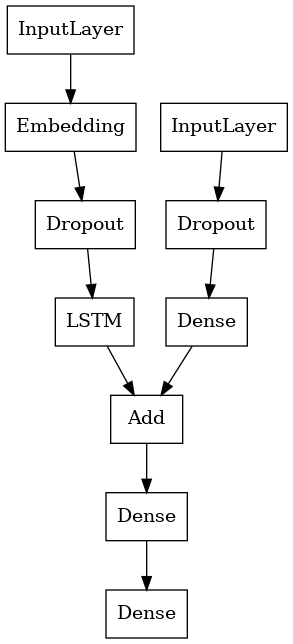

In [27]:
icg_model = tf_models.load_model(work_dir + '/icg_model_v29.h5')
plot_model(icg_model, show_shapes=False, show_layer_names=False)

In [28]:
def indexToWord(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# predict caption sequence for an image
def imgPredictCaption(model, imageFeatures, tokenizer, maxCaptionLength):
    # add start tag for generation process
    caption = 'sseq'
    # iterate over the max length of sequence
    for i in range(maxCaptionLength):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxCaptionLength)
        # predict next word
        predictions = model.predict([imageFeatures, sequence], verbose=0)
        # get word index with the highest probability
        outputWordIndex = np.argmax(predictions)
        # convert index to word
        word = indexToWord(outputWordIndex, tokenizer)
        # stop if word is not found in vocabulary
        if word is None:
            break
        # append word as input for generating next word
        caption += " " + word
        # stop if we reach the end of sequence
        if word == 'eseq':
            break
      
    return caption

# Prototype


      Actual Captions

sseq grey bird stands majestically on beach while waves roll in eseq
sseq large bird stands in the water on the beach eseq
sseq tall bird is standing on the sand beside the ocean eseq
sseq water bird standing at the ocean edge eseq
sseq white crane stands tall as it looks out upon the ocean eseq

      Generated Caption

sseq large black and white bird is walking on the beach eseq 



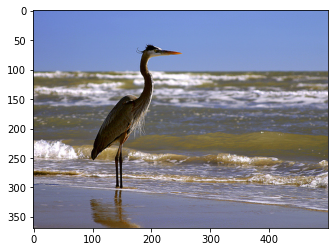

In [54]:
# load the image #1003163366_44323f5815
testImg_path = '/kaggle/input/flickr8k/Images/99679241_adc853a5c0.jpg'

def generateCaption(img_path):
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape image
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    image_features = model.predict(image, verbose=0)

    generated_caption = imgPredictCaption(icg_model, image_features, tokenizer, maxCaptionLength)
    plt.imshow(Image.open(img_path))
    actualCaptions = imgsWithCaptions['99679241_adc853a5c0']

    print("\n      Actual Captions\n")
    for caption in actualCaptions:
        print(caption)

    print("\n      Generated Caption\n")  
    print(generated_caption, "\n")
    
    
generateCaption(testImg_path)


# Test Model Accuracy in BLEU Score

In [55]:
actualCaptions = list()
predictedCaptions = list()

n = 0
for imageID in tqdm(testImgs):
    if n == 809:
        break
    # read the 5 actual captions of the image
    imgActualCaptions = imgsWithCaptions[imageID]
    
    #if(imageID == '539667015_fd0a3bea07'):
        #print(imgActualCaptions)
        #print('\n')
        
    # split each of the 5 captions into words (array of words with each caption)
    imgActualCaptions = [caption.split() for caption in imgActualCaptions]
    # append these actual captions to the total actual captions list
    actualCaptions.append(imgActualCaptions)
    
    # get the predicted caption of the image
    imgPredictedCaption = imgPredictCaption(icg_model, features[imageID], tokenizer, maxCaptionLength)   
    imgPredictedCaption = imgPredictedCaption.split()
    
    # append these predicted caption to the total predicted captions list
    predictedCaptions.append(imgPredictedCaption)
    n += 1

  0%|          | 0/810 [00:00<?, ?it/s]

In [57]:
from nltk.translate.bleu_score import corpus_bleu

print("BLEU-1: %f" %corpus_bleu(actualCaptions, predictedCaptions, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" %corpus_bleu(actualCaptions, predictedCaptions, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.532460
BLEU-2: 0.309517
